In [2]:
from pickle import load
from numpy import argmax

from keras.models import Model
from tensorflow.python.keras.models import load_model
from keras_preprocessing.image import load_img, img_to_array
from keras_preprocessing.sequence import pad_sequences

from os import listdir
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import preprocess_input as preprocess_input_i
from keras.applications.vgg16 import preprocess_input as preprocess_input_v

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
def map_int_to_word(integer, tokenizer):
    for word, idx in tokenizer.word_index.items():
        if idx == integer:
            return word

    return None


def generate_caption(model, tokenizer, max_words, image):
    in_text = 'start'

    for i in range(max_words):
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq], maxlen=max_words)

        y_hat = model.predict([image, seq], verbose=0)
        y_hat = argmax(y_hat)

        word = map_int_to_word(y_hat, tokenizer)
        if word is None:
            break

        in_text += ' ' + word

        if word == 'end':
            break

    return in_text


def print_image(path_image):
    image = mpimg.imread(path_image)
    plt.imshow(image)
    plt.show()


def extract_features(path_image, extractor, target_size, model_type):
    image = load_img(path_image, target_size=(target_size, target_size))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    if model_type == "vgg16":
        image = preprocess_input_v(image)
    elif model_type == "inception":
        image = preprocess_input_i(image)

    feature = extractor.predict(image, verbose=0)

    return feature


def generate_and_print_captions(path_image, extractor, target_size, models_paths, model_type, tokenizer, max_words):
    image_features = extract_features(path_image, extractor, target_size, model_type)

    for i, path in enumerate(models_paths):
        model = load_model(path)
        caption = generate_caption(model, tokenizer, max_words, image_features)
        print(str(i) + ' ' + caption)

In [4]:
dataset_path = "D:/Temp/Dataset/kaggle/flickr_30k" # основной путь к датасету
path_tokenizer = dataset_path + "/ru-tokenizer-train.pkl"
tokenizer = load(open(path_tokenizer, 'rb'))
max_words = 57

In [5]:
vgg16_extractor = VGG16()
vgg16_extractor = Model(inputs=vgg16_extractor.inputs, outputs=vgg16_extractor.layers[-2].output)
vgg16_target_size = 224

In [6]:
# функция для получения всех моделей из директории
def get_models(directory):
    result_array = []
    for name in listdir(directory):
        path_model = directory + '/' + name
        result_array.append(path_model)
    return result_array

In [7]:
vgg_models = get_models("vgg")
print(vgg_models)

['vgg/model-1.h5', 'vgg/model-10.h5', 'vgg/model-11.h5', 'vgg/model-12.h5', 'vgg/model-13.h5', 'vgg/model-14.h5', 'vgg/model-15.h5', 'vgg/model-16.h5', 'vgg/model-17.h5', 'vgg/model-18.h5', 'vgg/model-19.h5', 'vgg/model-2.h5', 'vgg/model-3.h5', 'vgg/model-4.h5', 'vgg/model-5.h5', 'vgg/model-6.h5', 'vgg/model-7.h5', 'vgg/model-8.h5', 'vgg/model-9.h5']


In [8]:
vgg_alt_models = get_models("alt_vgg")
print(vgg_alt_models)

['alt_vgg/model-0.h5', 'alt_vgg/model-1.h5', 'alt_vgg/model-10.h5', 'alt_vgg/model-11.h5', 'alt_vgg/model-12.h5', 'alt_vgg/model-13.h5', 'alt_vgg/model-2.h5', 'alt_vgg/model-3.h5', 'alt_vgg/model-4.h5', 'alt_vgg/model-5.h5', 'alt_vgg/model-6.h5', 'alt_vgg/model-7.h5', 'alt_vgg/model-8.h5', 'alt_vgg/model-9.h5']


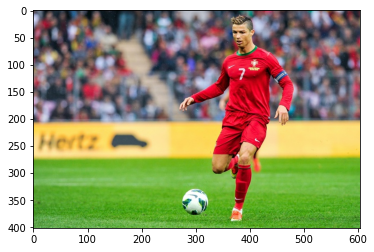

In [19]:
print_image('check.jpg')

In [10]:
print("Генерация подписей для моделей VGG16:")
generate_and_print_captions('check.jpg', vgg16_extractor, vgg16_target_size, vgg_models, "vgg16", tokenizer, max_words)

Генерация подписей для моделей VGG16:
0 start футболист прыгает на поле end
1 start бейсболист готовится бросить мяч end
2 start бейсболист готовится бросить мяч end
3 start бейсболист пытается забить гол end
4 start бейсболист пытается забить гол игроки противоположной команды смотрят end
5 start бейсболист бежит футболисту остывает end
6 start регбист поднят воздухе end
7 start футболисты играют футбол end
8 start бейсболист бежит футболисту красном шлеме end
9 start бейсболист пытается забить гол end
10 start игроки на футбольном поле end
11 start футболист готовится бросить мяч end
12 start футболист готовится ударить по мячу end
13 start футболист готовится бросить мяч end
14 start бейсболист готовится ударить по мячу end
15 start бейсболист готовится ударить по мячу end
16 start бейсболист готовится ударить по мячу end
17 start бейсболист готовится ударить по мячу end
18 start бейсболист готовится ударить по мячу end


In [11]:
from keras.layers import TimeDistributed, Bidirectional


def generate_and_print_custom_captions(path_image, extractor, target_size, models_paths, model_type, tokenizer, max_words):
    image_features = extract_features(path_image, extractor, target_size, model_type)

    for i, path in enumerate(models_paths):
        model = load_model(path, custom_objects = {"TimeDistributed": TimeDistributed, "Bidirectional": Bidirectional})

        caption = generate_caption(model, tokenizer, max_words, image_features)
        print(str(i) + ' ' + caption)

print("Генерация подписей для модифицированных моделей VGG16:")
generate_and_print_custom_captions('check.jpg', vgg16_extractor, vgg16_target_size, vgg_alt_models, "vgg16", tokenizer, max_words)

Генерация подписей для модифицированных моделей VGG16:
0 start регбист поднят воздухе end
1 start футболисты играют футбол end
2 start бейсболист готовится бросить мяч end
3 start бейсболист готовится бросить мяч end
4 start бейсболист пытается забить гол end
5 start бейсболист пытается забить гол игроки противоположной команды смотрят end
6 start бейсболист пытается забить гол end
7 start игроки на футбольном поле end
8 start бейсболист бежит футболисту остывает end
9 start регбист поднят воздухе end
10 start бейсболист готовится ударить по мячу end
11 start бейсболист бежит футболисту красном шлеме end
12 start бейсболист готовится ударить по мячу end
13 start бейсболист готовится ударить по мячу end


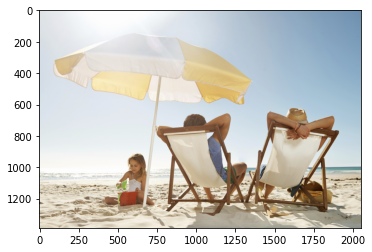

In [12]:
print_image('check_1.jpg')

In [13]:
print("Генерация подписей для моделей VGG16:")
generate_and_print_captions('check_1.jpg', vgg16_extractor, vgg16_target_size, vgg_models, "vgg16", tokenizer, max_words)

Генерация подписей для моделей VGG16:
0 start мужчина сидит на пляже end
1 start мужчина женщина сидят на пляже end
2 start мужчина женщина сидят на пляже end
3 start мужчина женщина сидят на причале на пляже end
4 start мужчина женщина сидят на причале на пляже end
5 start мужчина женщина сидят на пляже end
6 start мужчина женщина сидят на песке end
7 start группа людей на пляже end
8 start группа людей на пляже end
9 start группа людей стоит на пляже end
10 start группа людей на пляже end
11 start мужчина сидит на пляже end
12 start мужчина сидит на пляже end
13 start трое мужчин работают на пляже end
14 start трое мужчин играют на пляже end
15 start мужчина сидит на пляже смотрит на океан end
16 start мужчина женщина сидят на пляже end
17 start мужчина женщина сидят на пляже end
18 start мужчина женщина сидят на пляже end


In [14]:
print("Генерация подписей для модифицированных моделей VGG16:")
generate_and_print_custom_captions('check_1.jpg', vgg16_extractor, vgg16_target_size, vgg_alt_models, "vgg16", tokenizer, max_words)

Генерация подписей для модифицированных моделей VGG16:
0 start мужчина женщина сидят на песке end
1 start группа людей на пляже end
2 start мужчина женщина сидят на пляже end
3 start мужчина женщина сидят на пляже end
4 start мужчина женщина сидят на причале на пляже end
5 start мужчина женщина сидят на причале на пляже end
6 start группа людей стоит на пляже end
7 start группа людей на пляже end
8 start мужчина женщина сидят на пляже end
9 start мужчина женщина сидят на песке end
10 start мужчина сидит на пляже смотрит на океан end
11 start группа людей на пляже end
12 start мужчина женщина сидят на пляже end
13 start мужчина женщина сидят на пляже end


## Лучшие модели на основе оценок BLEU-4

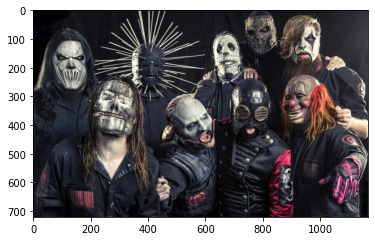

VGG16: start группа людей стоит на улице заваленной мусором end
ALT VGG16: start группа людей стоит на улице end


In [20]:
def generate_and_print_caption_the_best_vgg(path_image, extractor, target_size, model_type, tokenizer, max_words):
    image_features = extract_features(path_image, extractor, target_size, model_type)
    model = load_model('vgg/model-10.h5')
    print('VGG16: ' + generate_caption(model, tokenizer, max_words, image_features))

def generate_and_print_caption_the_best_alt_vgg(path_image, extractor, target_size, model_type, tokenizer, max_words):
    image_features = extract_features(path_image, extractor, target_size, model_type)
    model = load_model("alt_vgg/model-7.h5", custom_objects = {"TimeDistributed": TimeDistributed, "Bidirectional": Bidirectional})
    print('ALT VGG16: ' + generate_caption(model, tokenizer, max_words, image_features))

print_image('check_2.jpg')

generate_and_print_caption_the_best_vgg('check_2.jpg', vgg16_extractor, vgg16_target_size, vgg_models, tokenizer, max_words)

generate_and_print_caption_the_best_alt_vgg('check_2.jpg', vgg16_extractor, vgg16_target_size, vgg_models, tokenizer, max_words)

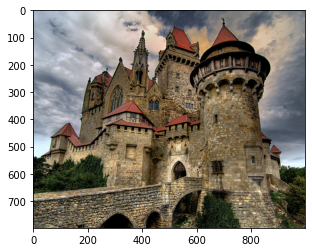

VGG16: start группа людей стоит на фоне большой статуи end
ALT VGG16: start люди смотрят на большие руины end


In [21]:
print_image('check_3.jpg')

generate_and_print_caption_the_best_vgg('check_3.jpg', vgg16_extractor, vgg16_target_size, vgg_models, tokenizer, max_words)

generate_and_print_caption_the_best_alt_vgg('check_3.jpg', vgg16_extractor, vgg16_target_size, vgg_models, tokenizer, max_words)

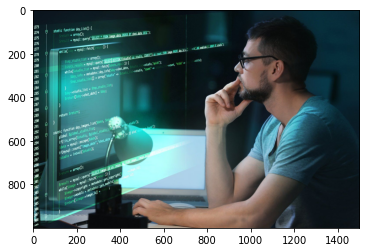

VGG16: start мужчина играет на аккордеоне end
ALT VGG16: start мужчина играет на аккордеоне end


In [23]:
print_image('check_4.jpg')

generate_and_print_caption_the_best_vgg('check_4.jpg', vgg16_extractor, vgg16_target_size, vgg_models, tokenizer, max_words)

generate_and_print_caption_the_best_alt_vgg('check_4.jpg', vgg16_extractor, vgg16_target_size, vgg_models, tokenizer, max_words)